# Tiled image processing

In this notebook we will process a big dataset that has been saved in zarr format to count cells in individual tiles using [dask](https://docs.dask.org/en/stable/) and [zarr](https://zarr.readthedocs.io/en/stable/). The underlying principles will be explained in the next sections.

In [1]:
import zarr
import dask.array as da
import numpy as np
import stackview

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed [License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ). The biological background is explained in [Suckert et al. 2020](https://www.sciencedirect.com/science/article/abs/pii/S0167814020301043), where we also applied a similar workflow. 

When working with big data, you will likely have an image stored in the right format to begin with. For demonstration purposes, we save here a test image into the zarr format, which is commonly used for handling big image data.

## Loading the zarr-backed image data
For processing images tile-by-tile, the data must be stored in a compatible file format in advance, for example as zarr file.

In [2]:
zarr_image = zarr.open("data/P1_H_C3H_M004_17-cropped.zarr", mode="r")
zarr_image.info

Type               : Array
Zarr format        : 3
Data type          : UInt8()
Fill value         : 0
Shape              : (2000, 5000)
Chunk shape        : (100, 100)
Order              : C
Read-only          : True
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=None)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 10000000 (9.5M)

Such a zarr dataset can be converted to a [Dask stack](https://docs.dask.org/en/latest/array-stack.html):

In [3]:
da.from_zarr(zarr_image)

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

We can also apply image processing to this tiled dataset directly.

## Counting nuclei
For counting the nuclei, we setup a simple image processing workflow. It returns an image with a single pixel containing the number of nuclei in the given input image. These single pixels will be assembled to a pixel count map; an image with much less pixels than the original image, but with the advantage that we can look at it - it's no big data anymore.cle.exclude_labels_with_map_values_within_range

In [4]:
import numpy as np
from skimage import filters, segmentation, measure, morphology
from scipy import ndimage

def count_nuclei(image, threshold=15):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    #print("processing image of shape", image.shape)
    # Count nuclei including those which touch the image border
    # Replace voronoi_otsu_labeling with equivalent scikit-image approach
    blurred = filters.gaussian(np.asarray(image), sigma=3.5, preserve_range=True)
    binary = blurred > threshold
    
    # Generate seeds for watershed
    distance = ndimage.distance_transform_edt(binary)
    local_maxima = morphology.local_maxima(distance, footprint=morphology.disk(1))
    seeds = measure.label(local_maxima)
    
    # Perform watershed segmentation
    labels = segmentation.watershed(-distance, seeds, mask=binary)
    
    # Relabel to ensure sequential numbering
    nuclei_count = labels.max()
    
    # Count nuclei excluding those which touch the image border
    labels_without_borders = segmentation.clear_border(labels.copy())
    
    # Relabel again
    labels_without_borders = measure.label(labels_without_borders > 0)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    return result

For testing, we apply the function to a subset of the data.

[[ 0  0  0 ...  9 12 15]
 [ 0  0  0 ... 12 12 16]
 [ 0  0  0 ... 18 18 17]
 ...
 [68 41 31 ...  0  0  0]
 [82 36 30 ...  0  0  0]
 [52 27 25 ...  0  0  0]]
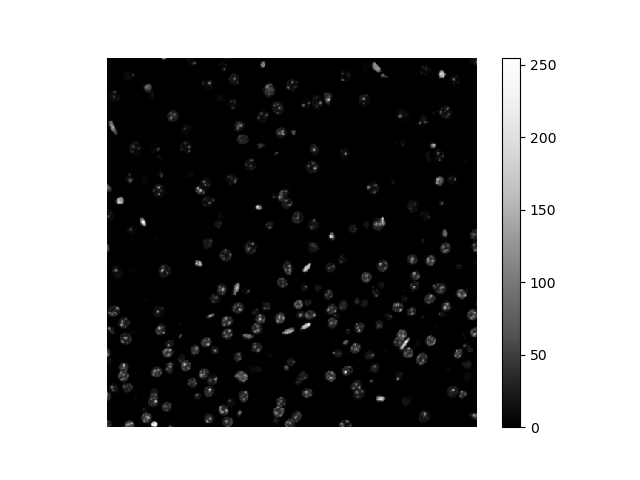
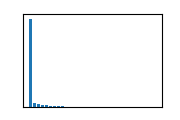

In [5]:
image_crop = np.asarray(zarr_image[1000:1500, 1000:1500])

stackview.insight(image_crop)

In [6]:
count_nuclei(image_crop)

array([[172.]])

Next, we setup a _delayed_ result by mapping a function on blocks of the data.

In [7]:
tile_map = da.map_blocks(count_nuclei, da.from_zarr(zarr_image))

tile_map

dask.array<count_nuclei, shape=(2000, 5000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

As this result image is orders of magnitude smaller then the original, we can compute the whole result map. This is because the count nuclei function reduces the data massively. Each block is turned into a single number.

In [8]:
result = tile_map.compute()

In [9]:
result.shape

(20, 50)

The sum of intensity of all pixels in this image corresponds to the counted number of nuclei in the original image.

In [10]:
result.sum()

np.float64(5545.0)

Again, as the result map is small, we can just visualize it.

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.5  4.   4.
   4.5  8.5  5.5  2.   4.   1.5  4.   2. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.5  1.   6.5  4.   4.5  1.5  3.5
   2.5  3.5  2.5  6.   9.5 11.5  4.5  9. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.5  5.5  6.   7.5  3.   3.   2.5  3.   4.   3.5  2.   5.
  11.5  8.   9.   8.   6.5  8.   7.   6.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.5  6.   6.5  3.5  2.   0.   2.5  3.   6.5  6.5  5.5  7.5  8.   3.5
   6.   6.   9.5  7.   4.   3.   6.5  6. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.5  0.   0.   4.5  6.5
   4.   9.   1.5  3.5  3.5  7.  10.   9.   7.   8.   4.   6.5  3.5  6.
   6.   9.5  2.5 11.5 12.   8.5  9.   5. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   4.   4.5  3.5  5.   5.5  8.5  6.5  6.5  6.5  2.   2.
   5.   1.5  7.5  4.5 10.5  9.   8.5  6.   6.5  5.5  6.   4.5  7.5  2.5
   5.   7.5  6.   8.  11.5  8.5  7.5  8.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.
   2.5  5.5  4.   1.5  1.5  1.5  0.   0.5  2.5  3.5  5.5 12.   4.   6.5
   4.5  7.5  4.5  3.5  4.5  3.5  4.   5.   8.  10.  11.   8.5  8.   7.
  12.5  6.  10.5  8.   9.   7.  10.5  6.5]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0.   0.5  0.5  7.   8.   2.5
   1.   4.5  5.5  4.5  7.   6.5  6.5  6.5  6.5  5.   6.5  6.5  7.5  7.
   4.5  7.5  5.5  4.5  6.   9.5  4.   3.  11.   4.5  7.  10.   8.   9.5
   7.   5.5  4.5  4.5  5.5  7.   6.5  6.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  5.   2.   3.5  0.5  5.   1.
   3.5  7.5  1.5  5.5  6.   5.   4.5  2.   3.   6.5  2.5  8.   8.  10.
   5.5  6.5  4.5  2.5  5.   8.   5.5  6.   7.   4.5  9.5 12.5  8.5  7.5
   6.   5.5  9.   4.5  7.   9.5  9.5  6.5]
 [ 0.   0.   0.   0.   0.   0.5  6.   5.   6.5  4.   6.5  8.5  7.5  3.5
   5.   7.5  4.   2.5  7.5  6.   5.5  4.5  4.5  5.   6.5  4.  12.   7.
   5.   4.5  2.5  4.5  7.   9.   7.   5.   9.   6.5 12.   3.   4.   4.5
   8.   6.   4.5  4.5  7.5  7.   8.5  6. ]
 [ 0.   0.   0.   2.5  3.5  7.   5.5  3.5  7.5  5.5  5.5  3.   7.5  3.
   3.5  5.5  7.   5.   2.5  4.5  4.   8.   4.   3.5  6.5  3.5  8.5 10.5
   8.  10.5  8.   9.   9.5 11.   9.5  9.   5.   5.5  3.   2.  11.   5.5
   6.5  4.5  8.5  9.5 11.  12.   8.   6.5]
 [ 0.   1.   5.5  6.5  2.5  2.   3.   5.   3.5  5.   4.5  8.5  6.5  2.
   4.   4.5  5.   8.5 10.   8.5  7.5  4.   8.   6.   3.   8.5 11.5 14.
   4.5 12.5 10.   7.5  9.   5.   9.5  8.   9.5  5.   4.5  6.5  3.   5.5
   8.   4.5  7.   6.5 12.   7.5  5.  12.5]
 [ 0.5  6.   2.5  6.5  5.5  3.   4.5 10.   5.5  5.5  4.   3.5  8.   4.5
   7.   8.5 10.5 10.5  8.5  8.5  8.  14.5  9.  20.5 14.  10.  11.  15.
  12.   5.   6.5  3.5  6.5  3.   6.   6.   7.  11.   7.   7.   3.5  5.5
   4.5  9.  12.  10.   8.5  6.5 10.  11.5]
 [ 7.   4.5  4.5  2.5  3.   5.5  6.   4.5  6.5  9.   7.5 12.5 11.   9.5
   9.5  8.   5.5 10.5  8.   8.5 11.5  9.5  7.5  5.5  5.5  8.   8.5  5.5
   6.   4.5  8.5  5.   8.   6.   6.   5.   8.   7.   8.   4.   5.5  5.
  11.   8.  13.5 17.   4.5  7.5 10.5 14. ]
 [ 5.5 10.   7.5  4.5  4.   5.5  7.5  5.   8.5 12.  12.  14.   8.   8.
   5.5  5.5  7.   5.5  8.5  6.   3.5  5.5  3.5  3.   2.5  6.   6.5  9.
   7.5 10.5  7.5  4.5  3.   8.   9.   6.5  3.5  8.   7.5  8.   4.   7.5
  13.5  5.  10.5  9.  10.5  9.  10.5 10. ]
 [ 8.  15.   4.   9.5  5.5  5.5  7.5  9.  12.5 12.   9.5 14.5  5.   6.5
   2.5  6.   4.5  5.5  7.   8.5  9.5  6.5  5.   6.   7.5  8.5  7.5  3.
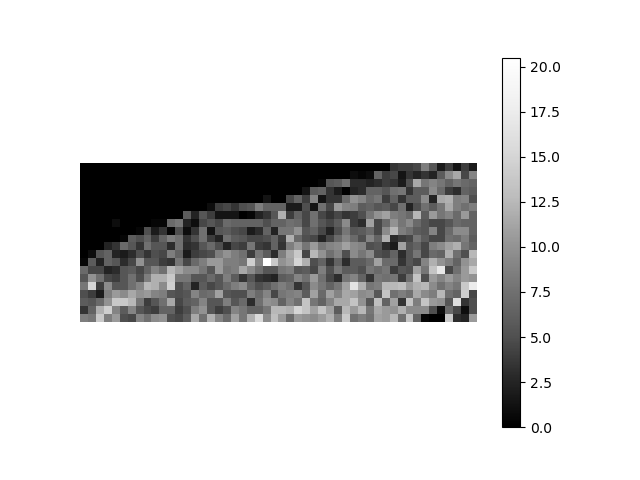
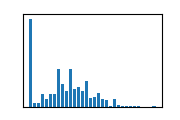

In [11]:
stackview.insight(result)

## Sanity check
Applying the `count nuclei` function to the whole zarr image allows us to check for the error of the computation above.

Note that this would not work with _big_ data.

In [12]:
count_nuclei(np.asarray(zarr_image))

array([[5423.5]])

# Exercise
Use the function `da.from_zarr(zarr_image).rechunk((500, 500))` to apply `cound_nuclei` to differently chunked data. Depending on the chunk size, the error of the method seems different. why?